In [1]:
import cv2
import numpy as np
import pandas as pd
import statistics
import torch
import os
import time
import matplotlib.pyplot as plt
import math
import torch.nn.functional as F
import torchvision.transforms as tf
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
from PIL import Image
from collections import OrderedDict
import seaborn as sns
from pathlib import Path
from shutil import copy2

torch.cuda.empty_cache()


In [2]:
modelA = torch.load('MODELS/modelA_bw_2cats_float_balanced_resnet18_withTL.pth',map_location=torch.device('cuda'))
modelB = torch.load('MODELS/modelB_bw-float_balanced_resnet18_wTL.pth',map_location=torch.device('cuda'))

In [3]:
print(modelA)
print(modelB)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [4]:


Image.MAX_IMAGE_PIXELS = None
sample, sample_length = ('Candela_overview_newside_oriented',0)
#sample, sample_length = ('Garth_base_oriented',24251)
sample_path = 'DEV_images/'

zoom=1

cutoff = 0.7

pixels_per_image = 256


trans = tf.Compose([tf.Resize((256,256)),
                  tf.ToTensor(),
                   ])

In [5]:

Path(sample_path+sample).mkdir(parents=True, exist_ok=True)
output_path = sample_path+sample
xAxis = 'px' if sample_length == 0 else 'um'
copy2(f'{sample_path}{sample}.jpg', f'{sample_path}{sample}/{sample}.jpg', follow_symlinks=True)

full_sample = Image.open(f'{sample_path}{sample}.jpg')
if len(full_sample.getbands())>1:
    full_sample = np.array(Image.open(f'{sample_path}{sample}.jpg').getchannel('G'))
else:
    full_sample = np.array(Image.open(f'{sample_path}{sample}.jpg'))


pixels_per_image = 256

h_in = int(pixels_per_image/zoom)
w_in = h_in

h = full_sample.shape[0]
w = full_sample.shape[1]

n_h = h//h_in
n_w = w//w_in

r_h = h%h_in
r_w = w%w_in

print(f'height: {h} pixels,width: {w} pixels')
print(f'images in height: {n_h},images in width: {n_w}')
print(f'lost pixels in height: {r_h}, lost pixels in width: {r_w}')

full_sample = full_sample[int(r_h/2):(h-int(r_h/2)),int(r_w/2):(w-int(r_w/2))]
if xAxis == 'um':
    um_per_pixel_w = sample_length/w
    um_per_image_w = um_per_pixel_w * pixels_per_image
    image_beginning = np.array([i*um_per_image_w for i in range(n_w)])
    image_end = image_beginning + um_per_image_w

height: 7330 pixels,width: 24862 pixels
images in height: 28,images in width: 97
lost pixels in height: 162, lost pixels in width: 30


In [6]:


quality_matrix = np.zeros((n_h,n_w), dtype = float) 
layer_matrix = np.zeros((n_h,n_w), dtype = float)


w_point = 0
start_time = time.time()

for j in range(n_w):
    if j%int(n_w/10) ==0:
        print(f'{j//int(n_w/10)*10:.0F}%')
    h_point = 0
    for i in range(n_h):        
        active_image = full_sample[h_point:h_point+h_in,w_point:w_point+w_in]
        active_image = Image.fromarray(active_image)

        h_point+=h_in

        quality_matrix[i,j] =  modelA(trans(active_image).view(1,1,256,256).cuda()).item()

        if quality_matrix[i,j]>=cutoff:
            layer_matrix[i,j] =  modelB(trans(active_image).view(1,1,256,256).cuda()).item()

    w_point+=w_in

print(time.time()-start_time)

quality_matrix[quality_matrix<0] = 0
quality_matrix[quality_matrix>1] = 1
quality_matrix


0%
10%
20%
30%
40%
50%
60%
70%
80%
90%
100%
48.12204027175903


array([[0.01144893, 0.00779843, 0.00711817, ..., 0.00089901, 0.0054645 ,
        0.00346151],
       [0.        , 0.00578054, 0.00610258, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.0056259 , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.00224158, 0.00198856, 0.00956838, ..., 0.08328702, 0.04160783,
        0.        ],
       [0.00607907, 0.        , 0.00267249, ..., 0.        , 0.        ,
        0.        ],
       [0.00819957, 0.0074714 , 0.00544403, ..., 0.00589097, 0.00668897,
        0.00906434]])

In [7]:
#save model


tosave = pd.DataFrame(quality_matrix)
tosave.head()
tosave.to_csv(f'{sample_path}{sample}/{sample}_{zoom}_qm_float.csv',index=False, header=True)

tosave = pd.DataFrame(layer_matrix)
tosave.head()
tosave.to_csv(f'{sample_path}{sample}/{sample}_{zoom}_lm_float.csv',index=False, header=True)


In [8]:

#load model
toload=pd.read_csv(f'{sample_path}{sample}/{sample}_{zoom}_qm_float.csv')
quality_matrix = toload.to_numpy()


toload=pd.read_csv(f'{sample_path}{sample}/{sample}_{zoom}_lm_float.csv')
layer_matrix = toload.to_numpy()

In [9]:
full_sample_quality_density_bin = np.zeros((full_sample.shape[0],full_sample.shape[1]), dtype = float)
full_sample_layer_density_bin = np.zeros((full_sample.shape[0],full_sample.shape[1]), dtype = float)
full_sample_cutoff_bin = full_sample.copy()

for j in range(full_sample.shape[1]-1):
    for i in range(full_sample.shape[0]):

        #position 1#
        try:
            full_sample_quality_density_bin[i,j]=quality_matrix[i//h_in,j//w_in]
            full_sample_layer_density_bin[i,j]=layer_matrix[i//h_in,j//w_in]
            if quality_matrix[i//h_in,j//w_in] <cutoff:
                full_sample_cutoff_bin[i,j]= 0 
        except:
            full_sample_quality_density_bin[i,j]=0
            full_sample_layer_density_bin[i,j]=0
            full_sample_cutoff_bin[i,j]= 0




    if j%int(full_sample.shape[1]/10)==0:
        pass
        #print(f'{j/int(full_sample.shape[1])*100:.0F}%')

In [10]:



carlo = []
num_sim = 10000
for i in range(num_sim):

    if i%int((num_sim-1)/10)==0:
        print(f'{i/(num_sim-1)*100:.0F}%')

    carlo_count = 0.0
    for j in range(layer_matrix.shape[1]-1):
        popul = layer_matrix[:,j][layer_matrix[:,j]!=0]
        try:
            carlo_count += np.float(np.random.choice(popul,1,replace=False))
        except:
            pass
    carlo.append(carlo_count)

layer_reduced=[]
sd=[]
sem=[]
avg=[]
n=[]
if xAxis == 'um':
    sd_umperlayer=[]
    sem_umperlayer=[]
classified_len=0
classified_tot=0

for j in range(layer_matrix.shape[1]-1):


    popul = layer_matrix[:,j][layer_matrix[:,j]!=0]
   # try: 
    layer_reduced.append(popul)
    if popul.size == 0:
        sd.append(0)
        sem.append(0)
        avg.append(0)
        n.append(0)
        if xAxis == 'um':
            sd_umperlayer.append(0)
            sem_umperlayer.append(0)
    else:

        classified_len+=1
        classified_tot+=popul.size

        sd.append(np.std(popul))       
        avg.append(np.mean(popul))
        n.append(popul.size)
        sem.append(np.std(popul)/np.sqrt(popul.size))
        if xAxis == 'um':
            sd_umperlayer.append(np.std(um_per_image_w/popul))     
            sem_umperlayer.append(np.std(um_per_image_w/popul)/np.sqrt(popul.size))





sd.append(0)
sem.append(0)
avg.append(0)
n.append(0)
if xAxis == 'um':
    sd_umperlayer.append(0)
    sem_umperlayer.append(0)

classified_len = classified_len/n_w*100
classified_tot = classified_tot/(n_w*n_h)*100

missing_len = 100-classified_len
missing_tot = 100-classified_tot


print(f'Of the total length, {classified_len:.1F} % were counted. \nOf all images submitted, {classified_tot:.1F} % were classified')



0%
10%
20%
30%
40%
50%
60%
70%
80%
90%
100%
Of the total length, 0.0 % were counted. 
Of all images submitted, 0.0 % were classified


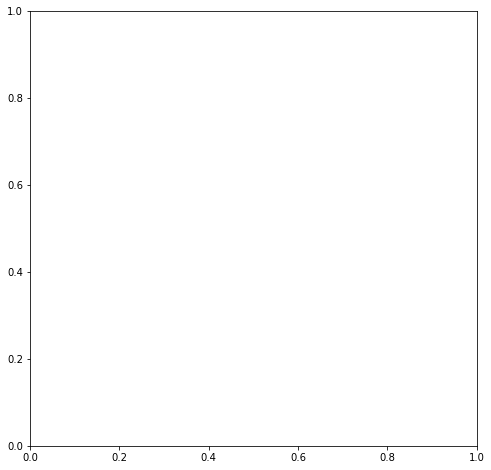

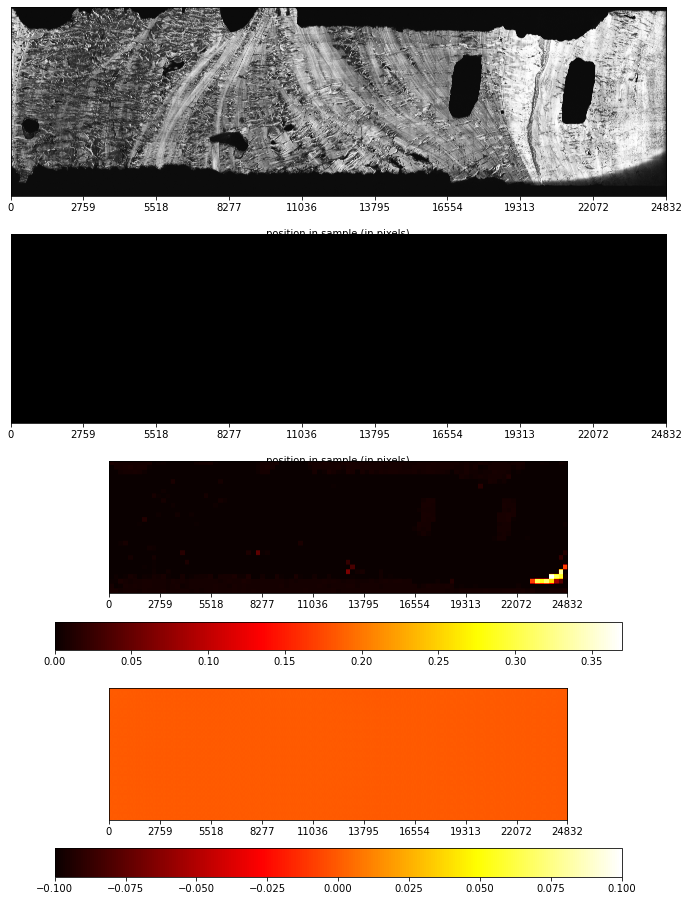

In [11]:

output_file = pd.DataFrame()

output_file['from_px']=[i*pixels_per_image/zoom for i in range(0,n_w)]
output_file['to_px']=output_file['from_px']+pixels_per_image/zoom-1
output_file['avg']=avg
output_file['countable_imgs']=n
output_file['sd']=sd
output_file['sem']=sem

if xAxis == 'um':

    output_file['from_um']=image_beginning
    output_file['to_um']=image_end
    output_file['sem_umperlayer']=sem_umperlayer
    output_file['sd_umperlayer']=sd_umperlayer
    output_file['umperlayer']= np.divide((output_file['to_um']-output_file['from_um']),
                                         output_file['avg'],out=np.zeros_like(output_file['avg']),where=output_file['countable_imgs']!=0)




#np.divide(a, b, out=np.zeros_like(a), where=b!=0)

minimum_carlo = round(min(carlo))
maximum_carlo = round(max(carlo))
avg_carlo = round(statistics.mean(carlo))
med_carlo = round(statistics.median(carlo))
sd_carlo=round(statistics.stdev(carlo))
stepsize_carlo = int((maximum_carlo-minimum_carlo)/20)

try:
    fig,(ax1) = plt.subplots(nrows=1,ncols=1, sharex=False)
    fig.set_figheight(8)
    fig.set_figwidth(8)

    ax1.hist(carlo,bins=(range(minimum_carlo,maximum_carlo+stepsize_carlo,stepsize_carlo)))
    ax1.axvline(avg_carlo, color='k', linestyle='dashed', linewidth=1)
    ax1.text(avg_carlo+stepsize_carlo, stepsize_carlo, 'Mean: {:.2f}'.format(avg_carlo))

    ax1.set_xlabel('n total layers in sample')
    ax1.set_ylabel('count of Monte Carlo (10000)')
    ylim=ax1.get_ylim()[1]*1.5
    ax1.set_ylim(0,ylim)

    ax1.text(minimum_carlo-stepsize_carlo/2,ylim*0.70,f'''Number of recombinations: 10,000
    Sample Name: {sample}
    Zoom: {zoom}x
    % total sample analyzed:{classified_tot:.1F}%
    % length sample analyzed:{classified_len:.1F}%
    Minimmun number of layers: {minimum_carlo}
    Maximum number of layers: {maximum_carlo}
    Average number of layers:{avg_carlo}
    Median number of layers: {med_carlo}
    SD of the simulation: {sd_carlo}''')




    stamp = time.strftime("%Y%m%d%H%M%S", time.gmtime())

    plt.savefig('{}{}/monte_carlo_{}_{}_{}.png'.format(sample_path,sample,sample, zoom, str(stamp)))

    plt.show()
except:
    pass

#potentially temporary solution for graphing

pixel=[]
avg=[]
sd=[]
sem=[]
n=[]
if xAxis == 'um':
    umperlayer=[]
    sd_umperlayer=[]
    sem_umperlayer=[]

for _,i in output_file.iterrows():
    pixel_temp=[]
    avg_temp=[]
    sd_temp=[]
    sem_temp=[]
    n_temp=[]
    if xAxis == 'um':

        umperlayer_temp=[]
        sd_umperlayer_temp=[]
        sem_umperlayer_temp=[]

    for j in range(int(i['from_px']),int(i['to_px'])):
        pixel_temp.append(j)
        avg_temp.append(i['avg'])
        sd_temp.append(i['sd'])
        sem_temp.append(i['sem'])
        n_temp.append(i['countable_imgs'])
        if xAxis == 'um':
            umperlayer_temp.append(i['umperlayer'])
            sd_umperlayer_temp.append(i['sd_umperlayer'])
            sem_umperlayer_temp.append(i['sem_umperlayer'])



    pixel.extend(pixel_temp)
    avg.extend(avg_temp)
    sd.extend(sd_temp)
    sem.extend(sem_temp)
    n.extend(n_temp)
    if xAxis == 'um':
        umperlayer.extend(umperlayer_temp)
        sd_umperlayer.extend(sd_umperlayer_temp)
        sem_umperlayer.extend(sem_umperlayer_temp)

output_file_pixel=pd.DataFrame()

output_file_pixel['px']=pixel
output_file_pixel['countable_imgs']=n

output_file_pixel['avg']=avg

output_file_pixel['sd']=sd

output_file_pixel['sem']=sem
if xAxis == 'um':
    output_file_pixel['umperlayer']=umperlayer
    output_file_pixel['sd_umperlayer']=sd_umperlayer
    output_file_pixel['sem_umperlayer']=sem_umperlayer
    fig,(ax1,ax2,ax3,ax4,ax5) = plt.subplots(nrows=5,ncols=1, sharex=False)

else:
    fig,(ax1,ax2,ax3,ax4) = plt.subplots(nrows=4,ncols=1, sharex=False)



#ax1.set_xticklabels()
fig.set_figheight(16)
fig.set_figwidth(15)


ax1.imshow(full_sample, cmap='gray')
ax1.set_yticks([])
ax1.set_xticks(np.round(np.linspace(0,full_sample.shape[1],10)))
if xAxis == 'um':
    ax1.set_xticklabels(np.linspace(0,um_per_pixel_w*full_sample.shape[1],10,dtype=int))
    ax1.set_xlabel('\n position in sample (in um) \n \n')

else:
    ax1.set_xticklabels(np.linspace(0,full_sample.shape[1],10,dtype=int))
    ax1.set_xlabel('\n position in sample (in pixels) \n \n')



flm = ax2.imshow(full_sample_cutoff_bin,cmap='gray')
#fig.colorbar(flm, ax = ax2, orientation='horizontal')
ax2.set_xticks(np.round(np.linspace(0,full_sample.shape[1],10)))
if xAxis == 'um':
    ax2.set_xticklabels(np.linspace(0,um_per_pixel_w*full_sample.shape[1],10,dtype=int))
    ax2.set_xlabel('\n position in sample (in um) \n \n')
else:
    ax2.set_xticklabels(np.linspace(0,full_sample.shape[1],10,dtype=int))
    ax2.set_xlabel('\n position in sample (in pixels) \n \n')
ax2.set_yticks([])



qm = ax3.imshow(full_sample_quality_density_bin,cmap='hot')
ax3.set_xticks(np.round(np.linspace(0,full_sample.shape[1],10)))
if xAxis == 'um':
    ax3.set_xticklabels(np.linspace(0,um_per_pixel_w*full_sample.shape[1],10,dtype=int))
    ax3.set_xlabel('\n position in sample (in um) \n \n')
else:
    ax3.set_xticklabels(np.linspace(0,full_sample.shape[1],10,dtype=int))
    ax3.set_xlabel('\n position in sample (in pixels) \n \n')

ax3.set_yticks([])
fig.colorbar(qm, ax = ax3, orientation='horizontal')


lm = ax4.imshow(full_sample_layer_density_bin,cmap='hot')
ax4.set_xticks(np.round(np.linspace(0,full_sample.shape[1],10)))
if xAxis == 'um':
    ax4.set_xticklabels(np.linspace(0,um_per_pixel_w*full_sample.shape[1],10,dtype=int))
    ax4.set_xlabel('\n position in sample (in um) \n \n')
else:
    ax4.set_xticklabels(np.linspace(0,full_sample.shape[1],10,dtype=int))
    ax4.set_xlabel('\n position in sample (in pixels) \n \n')
ax4.set_yticks([])
fig.colorbar(lm, ax = ax4, orientation='horizontal')

if xAxis == 'um':
    ax5.plot( output_file_pixel['px'], output_file_pixel['umperlayer']+output_file_pixel['sd_umperlayer'],marker='', scalex = 0, markerfacecolor='red', markersize=12, color='red', linewidth=1,linestyle='--'  )
    ax5.plot( output_file_pixel['px'], (output_file_pixel['umperlayer']-output_file_pixel['sd_umperlayer']), marker='', scalex = 0, markerfacecolor='red', markersize=12, color='red', linewidth=1,linestyle='--'  )
    ax5.plot( 'px', 'umperlayer', data=output_file_pixel,marker='', scalex = 0, markerfacecolor='blue', markersize=12, color='blue', linewidth=2)
    ax5.set_xticks(np.round(np.linspace(0,full_sample.shape[1],10)))
    ax5.set_xticklabels(np.linspace(0,um_per_pixel_w*full_sample.shape[1],10,dtype=int))
    ax5.set_xlabel('\n position in sample (in um) \n \n')
    ax5.set_ylabel('layer-width in um')
else:
    pass
#             ax5.plot( output_file_pixel['px'], output_file_pixel['umperlayer']+output_file_pixel['sd_umperlayer'],marker='', scalex = 0, markerfacecolor='red', markersize=12, color='red', linewidth=1,linestyle='--'  )
#             ax5.plot( output_file_pixel['px'], (output_file_pixel['umperlayer']-output_file_pixel['sd_umperlayer']), marker='', scalex = 0, markerfacecolor='red', markersize=12, color='red', linewidth=1,linestyle='--'  )
#             ax5.plot( 'px', 'umperlayer', data=output_file_pixel,marker='', scalex = 0, markerfacecolor='blue', markersize=12, color='blue', linewidth=2)
#             ax5.set_xticks(np.round(np.linspace(0,full_sample.shape[1],10)))
#             ax5.set_xticklabels(np.linspace(0,um_per_pixel_w*full_sample.shape[1],10,dtype=int))
#             ax5.set_xlabel('\n position in sample (in um) \n \n')
#             ax5.set_ylabel('layer-width in um')


stamp = time.strftime("%Y%m%d%H%M%S", time.gmtime())
plt.savefig('{}{}/sample_layerDensity_{}_{}_{}.png'.format(sample_path,sample,sample,zoom, str(stamp)))
plt.show()

In [12]:
# #Click-Functionality

# pt1 = (0,0)
# pt2 = (0,0)

# click1 = False
# click2 = False

# pt3 = (0,0)
# pt4 = (0,0)

# click3 = False
# click4 = False

# zoom_frame = cv2.resize(full_sample.copy(),dsize=(int(full_sample.shape[1]/40),int(full_sample.shape[0]/40)))
            

# def zoomer(event,x,y,flags,param):

#     global pt1,pt2,click1,click2
    
#     if event == cv2.EVENT_LBUTTONDOWN:

#         if click1 == True and click2 == True:
#             click1 = False
#             click2 = False
#             pt1 = (0,0)
#             pt2 = (0,0)
            
#         elif click1 == False:
#             pt1 = (x,y)
#             click1 = True
            
#         elif click2 == False:
#             pt2 = (x,y)
#             click2 = True
            
    
#     return None

# def calc_layers(event,x,y,flags,param):
    
#     global pt3,pt4,click3,click4
    
#     if event == cv2.EVENT_LBUTTONDOWN:
    
#         if click3 == True and click4 == True:
#             click3 = False
#             click4 = False
#             pt3 = (0,0)
#             pt4 = (0,0)

#         elif click3 == False:
#             pt3 = (x,y)
#             click3 = True
            
#         elif click4 == False:
#             pt4 = (x,y)
#             click4 = True
        
        
    
#     return None


# cv2.namedWindow('sample')


# # Bind draw_rectangle function to mouse clicks
# cv2.setMouseCallback('sample', zoomer) 

# frame= cv2.resize(full_sample.copy(),dsize=(int(full_sample.shape[1]/40),int(full_sample.shape[0]/40)))

# while True:
    
#     if not click1 and not click2: 
#         frame= cv2.resize(full_sample.copy(),dsize=(int(full_sample.shape[1]/40),int(full_sample.shape[0]/40)))

    
#     if click1 and not click2: 
#         cv2.circle(frame, center=pt1, radius=4, color=(0,0,255), thickness=-1)
    
#     cv2.imshow('sample', frame)
       
#     #drawing rectangle
#     if click1 and click2:
#         cv2.rectangle(frame, pt1, pt2, (0, 0, 255), 2)
#         cv2.imshow('sample', frame)

#      #   cv2.namedWindow('Zoom')
#      #   cv2.setMouseCallback('Zoom', calc_layers) 

        
#         top_left=(40*min(pt1[0],pt2[0]),40*min(pt1[1],pt2[1]))
#         bottom_right=(40*max(pt1[0],pt2[0]),40*max(pt1[1],pt2[1]))
#       #  top_right=(bottom_right[0],top_left[1])
#       #  bottom_left=(bottom_right[1],top_left[0])
       
#         zoom_frame= full_sample.copy()[top_left[1]:bottom_right[1],top_left[0]:bottom_right[0]]
#         zoom_layers=full_sample_density_bin.copy()
#         zoom_layers=zoom_layers[top_left[1]:bottom_right[1],top_left[0]:bottom_right[0]]/h_in

#         while True:
        
#             cv2.setMouseCallback('Zoom', calc_layers) 
           
#             if not click3 and not click4: 
#                 zoom_frame= full_sample.copy()[top_left[1]:bottom_right[1],top_left[0]:bottom_right[0]]
                
        
#             if click3 and not click4: 
#                 cv2.circle(zoom_frame, center=pt3, radius=4, color=(255,0,0), thickness=-1)
    
            
#             if click3 and click4:
                       
#                 cv2.line(zoom_frame, pt3,pt4, (255, 0, 0), 1)
#                 cv2.arrowedLine(zoom_frame, pt4, (pt4[0],pt3[1]), (255, 0, 0), 1)
#                 cv2.line(zoom_frame, pt3, (pt4[0],pt3[1]), (0, 0, 255), 2)              
#                 cv2.namedWindow('Zoom')
                
#                 zoom_sum=zoom_layers[pt3[1],pt3[0]:pt4[0]].sum()
#                 cv2.putText(zoom_frame,str(int(round(zoom_sum,0))),pt3,cv2.FONT_HERSHEY_PLAIN,2,(255,255,255))
 
#             cv2.imshow('Zoom',zoom_frame)

#             if cv2.waitKey(1) & 0xFF == ord('q'):
#                 click1 = False
#                 click2 = False
#                 click3 = False
#                 click4 = False
#                 cv2.destroyWindow('Zoom') 
#                 cv2.setMouseCallback('sample', zoomer) 
#                 break

          
            
        
#     # Display the resulting frame

#     # This command let's us quit with the "q" button on a keyboard.
#     # Simply pressing X on the window won't work!
#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break

# # When everything is done, release the capture
# cv2.destroyAllWindows()

In [13]:
# cv2.destroyAllWindows()